In [1]:
from numba.cuda.cudadrv import enums
from numba import cuda

In [3]:
!wget -O img.jpeg https://file.io.vn/W3MG0J

--2025-10-06 11:48:30--  https://file.io.vn/W3MG0J
Resolving file.io.vn (file.io.vn)... 157.10.45.101
Connecting to file.io.vn (file.io.vn)|157.10.45.101|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://my.microsoftpersonalcontent.com/personal/de4e2fbd58f4f53b/_layouts/15/download.aspx?UniqueId=2375f846-15de-42e9-87e9-c31e5bebf509&Translate=false&tempauth=v1e.eyJzaXRlaWQiOiJiMWVkOTQ5Mi0wMDA3LTRhNWEtYjJmOC05MzA4OWQ4YzgwMmQiLCJhcHBfZGlzcGxheW5hbWUiOiJpaW5kZXgiLCJhcHBpZCI6ImQ4NWE5YTNhLTM4MzktNDkzMC05ZjE0LTgxOGEyZDQ0OWE0ZCIsImF1ZCI6IjAwMDAwMDAzLTAwMDAtMGZmMS1jZTAwLTAwMDAwMDAwMDAwMC9teS5taWNyb3NvZnRwZXJzb25hbGNvbnRlbnQuY29tQDkxODgwNDBkLTZjNjctNGM1Yi1iMTEyLTM2YTMwNGI2NmRhZCIsImV4cCI6IjE3NTk3NTQ5MTIifQ.NIacYc5wOw0J1_vnY4beVjwlzjqWZsqynFu6CbBjOmLePAdmrQ9GDdn7eesqIceNNaKBRaylrdIUBQdM9lZDn9RDuwiokQTQZ3Bzad7bZqWXYXtcYo8Jt2IehtuRNIFbVvrDqkMbiwA5hrTi197j9Xoym3P0ci4cQCSMNbEnSUYt6IQVSJwHetsN-_VcFAmH9aGuulzMyk9r6zF3-aDVPWxoAVCU-V1LxX1ianroiqfdK3sExvl1CQJMYU3aK_O1-

In [4]:
# from matplotlib import pyplot
import matplotlib

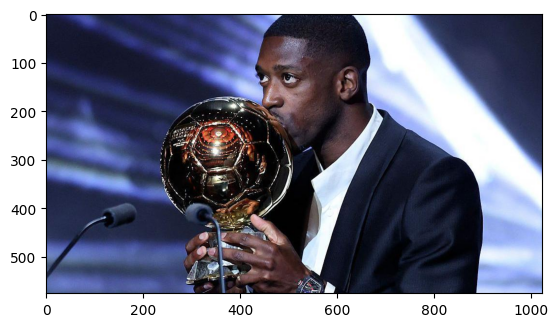

In [5]:
#Load the image
img = matplotlib.pyplot.imread('img.jpeg')

matplotlib.pyplot.imshow(img)

In [17]:
height, width, channels = img.shape
rgb_1d = img.reshape(height * width * 3)

In [7]:
import time

CPU time:  0.0051000118255615234


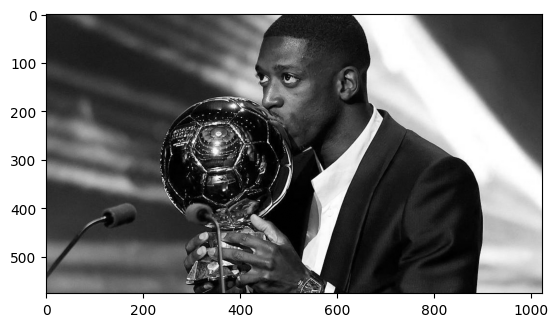

In [22]:
# CPU
start_time = time.time()
rgb_2d = rgb_1d.reshape(height, width, 3)
gray_2d = 1/3 * rgb_2d[:, :, 0] + 1/3 * rgb_2d[:, :, 1] + 1/3 * rgb_2d[:, :, 2]
end_time = time.time()
print("CPU time: ", end_time - start_time)
matplotlib.pyplot.imshow(gray_2d, cmap='gray')

In [9]:
from numba import jit, int32
import numpy as np
from numba import config
import matplotlib.pyplot as plt
config.CUDA_ENABLE_PYNVJITLINK = 1

In [10]:
@cuda.jit
def grayscale_2d(src, dst):
    x = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    y = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

    if x < src.shape[1] and y < src.shape[0]:
        r = src[y, x, 0]
        g = src[y, x, 1]
        b = src[y, x, 2]

        gray = np.uint8((r + g + b) / 3)

        dst[y, x, 0] = gray
        dst[y, x, 1] = gray
        dst[y, x, 2] = gray

GPU time:  0.0003333091735839844


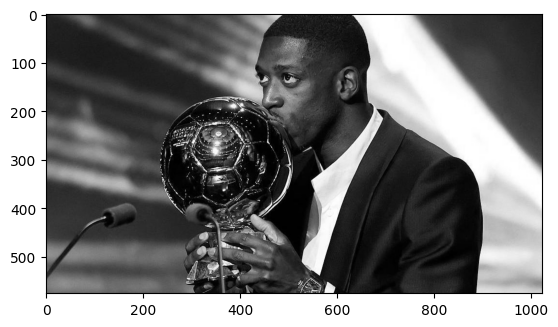

In [12]:
# mem allocate
gray_2d_empty = np.empty_like(rgb_2d)
devSrc = cuda.to_device(rgb_2d)
devDst = cuda.to_device(gray_2d_empty)

threads_per_block = (16, 16)
blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

start_time_gpu = time.time()
grayscale_2d[blocks_per_grid, threads_per_block](devSrc, devDst)
end_time_gpu = time.time()
hostDst = devDst.copy_to_host()

print("GPU time: ", end_time_gpu - start_time_gpu)
matplotlib.pyplot.imshow(hostDst.reshape(height, width, 3), cmap='gray')

Block Size: 16, GPU time: 0.0002040863037109375 seconds
Block Size: 32, GPU time: 0.00010704994201660156 seconds
Block Size: 64, GPU time: 0.00010013580322265625 seconds
Block Size: 128, GPU time: 9.1552734375e-05 seconds
Block Size: 256, GPU time: 9.226799011230469e-05 seconds
Block Size: 512, GPU time: 8.96453857421875e-05 seconds
Block Size: 1024, GPU time: 0.00010514259338378906 seconds


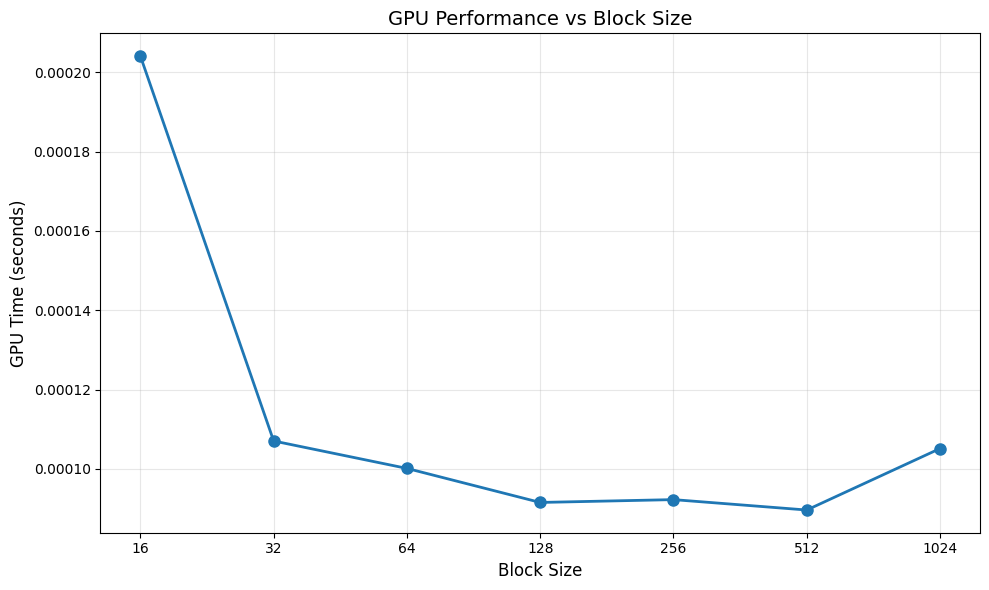

In [13]:
block_sizes = [16, 32, 64, 128, 256, 512, 1024]
gpu_times = []

for blockSize in block_sizes:
    threads_per_block = (blockSize, blockSize)

    gray_2d_empty = np.empty_like(rgb_2d)
    devSrc = cuda.to_device(rgb_2d)
    devDst = cuda.to_device(gray_2d_empty)

    threads_per_block = (16, 16)
    blocks_per_grid_x = (width + threads_per_block[0] - 1) // threads_per_block[0]
    blocks_per_grid_y = (height + threads_per_block[1] - 1) // threads_per_block[1]
    blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

    start_time_gpu = time.time()
    grayscale_2d[blocks_per_grid, threads_per_block](devSrc, devDst)
    end_time_gpu = time.time()
    hostDst = devDst.copy_to_host()

    gpu_time = end_time_gpu - start_time_gpu
    gpu_times.append(gpu_time)

    print(f"Block Size: {blockSize}, GPU time: {gpu_time} seconds")

plt.figure(figsize=(10, 6))
plt.plot(block_sizes, gpu_times, marker='o', linewidth=2, markersize=8)
plt.xlabel('Block Size', fontsize=12)
plt.ylabel('GPU Time (seconds)', fontsize=12)
plt.title('GPU Performance vs Block Size', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)
plt.xticks(block_sizes, block_sizes)
plt.tight_layout()
plt.show()

In [14]:
best_idx = min(gpu_times)
print(best_idx)

8.96453857421875e-05


Comparing with previous

In [24]:
@cuda.jit
def grayscale(src, dst):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  pixel_idx = tidx * 3
  if pixel_idx + 2 < src.shape[0]:
    g = np.uint8((src[pixel_idx] + src[pixel_idx + 1] + src[pixel_idx + 2]) / 3)
    dst[pixel_idx] = g
    dst[pixel_idx + 1] = g
    dst[pixel_idx + 2] = g

Block Size: 16, GPU time: 0.0005643367767333984 seconds
Block Size: 32, GPU time: 0.0002574920654296875 seconds
Block Size: 64, GPU time: 0.00027680397033691406 seconds
Block Size: 128, GPU time: 0.0002543926239013672 seconds
Block Size: 256, GPU time: 0.000255584716796875 seconds
Block Size: 512, GPU time: 0.000240325927734375 seconds
Block Size: 1024, GPU time: 0.0002617835998535156 seconds


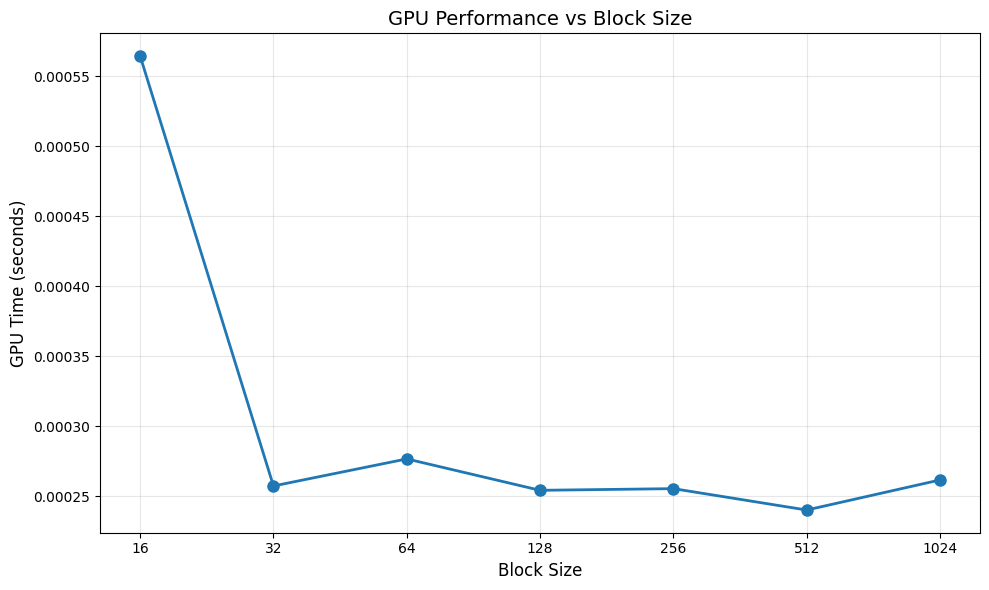

In [28]:
block_sizes = [16, 32, 64, 128, 256, 512, 1024]
gpu_times_1d = []

pixelCount = height * width

for blockSize in block_sizes:
    gridSize = (pixelCount + blockSize - 1) // blockSize

    devSrc = cuda.to_device(rgb_1d)
    devDst = cuda.device_array(height * width * 3, np.uint8)

    start_time_gpu = time.time()
    grayscale[gridSize, blockSize](devSrc, devDst)
    cuda.synchronize()
    end_time_gpu = time.time()

    gpu_time = end_time_gpu - start_time_gpu
    gpu_times_1d.append(gpu_time)

    print(f"Block Size: {blockSize}, GPU time: {gpu_time} seconds")

plt.figure(figsize=(10, 6))
plt.plot(block_sizes, gpu_times_1d, marker='o', linewidth=2, markersize=8)
plt.xlabel('Block Size', fontsize=12)
plt.ylabel('GPU Time (seconds)', fontsize=12)
plt.title('GPU Performance vs Block Size', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)
plt.xticks(block_sizes, block_sizes)
plt.tight_layout()
plt.show()

In [29]:
for i, blockSize in enumerate(block_sizes):
    speedup = gpu_times_1d[i] / gpu_times[i]
    print(f"Block Size: {blockSize} | 1D: {gpu_times_1d[i]}s | 2D: {gpu_times[i]}s | Speedup: {speedup}x")

Block Size: 16 | 1D: 0.0005643367767333984s | 2D: 0.0002040863037109375s | Speedup: 2.7651869158878504x
Block Size: 32 | 1D: 0.0002574920654296875s | 2D: 0.00010704994201660156s | Speedup: 2.4053452115812917x
Block Size: 64 | 1D: 0.00027680397033691406s | 2D: 0.00010013580322265625s | Speedup: 2.7642857142857142x
Block Size: 128 | 1D: 0.0002543926239013672s | 2D: 9.1552734375e-05s | Speedup: 2.7786458333333335x
Block Size: 256 | 1D: 0.000255584716796875s | 2D: 9.226799011230469e-05s | Speedup: 2.7700258397932815x
Block Size: 512 | 1D: 0.000240325927734375s | 2D: 8.96453857421875e-05s | Speedup: 2.6808510638297873x
Block Size: 1024 | 1D: 0.0002617835998535156s | 2D: 0.00010514259338378906s | Speedup: 2.489795918367347x
